# Imports

In [1]:
from skimage.segmentation import watershed, felzenszwalb
from skimage.filters import sobel
import pandas as pd
from pathlib import Path
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.filters import rank
from scipy import ndimage as ndi
from skimage.morphology import disk
import sklearn.metrics

# Setup

First, you need to access the data from this colab.

A way to do this is to add the following shared drive to your google drive:
https://drive.google.com/drive/folders/1AfBKbAmrMTLLH33441c5RSlwLp3ePhVT?usp=share_link


In order to do this, just rick-click on the drive and click "Add a shortcut to my Drive"

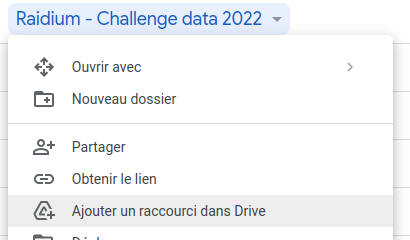

# Handling the data

In [2]:
# Load the train labels
# Note the transpose!
data_dir = Path("./../data/")
labels_train = pd.read_csv(data_dir  / "Y_train.csv", index_col=0).T

In [3]:
# Here is a function to load the data
def load_dataset(dataset_dir):
    dataset_list = []
    # Note: It's very important to load the images in the correct numerical order!
    for image_file in list(sorted(Path(dataset_dir).glob("*.png"), key=lambda filename: int(filename.name.rstrip(".png")))):
        dataset_list.append(cv2.imread(str(image_file), cv2.IMREAD_GRAYSCALE))
    return np.stack(dataset_list, axis=0)

In [4]:
# Load the train and test sets
# If you've put the shortcut directly in your drive, this should work out of the box
# Else, edit the path
data_dir = Path("./../data/")
data_train = load_dataset(data_dir / "X_train")
data_test = load_dataset(data_dir / "X_test")

In [5]:
# The train data is a numpy array of 1000 images of 512*512
print(f"X_train shape: {data_train.shape}")
# The train label is a dataframe of 1000 rows with 262144 (=512x512) columns
print(f"Y_train shape: {labels_train.shape}")

X_train shape: (1000, 512, 512)
Y_train shape: (1000, 262144)


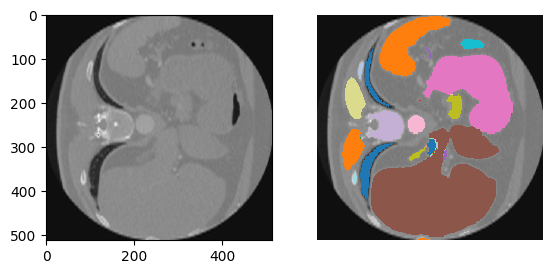

In [6]:
# Let's display some data
# Here is a function to display side by side a slide and a segmented mask
def plot_slice_seg(slice_image, seg):
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(slice_image, cmap="gray")
    axes[1].imshow(slice_image, cmap="gray")
    seg_masked = np.ma.masked_where(seg.reshape((512,512)) == 0, (seg.reshape((512,512))))
    axes[1].imshow(seg_masked, cmap="tab20")
    plt.axis("off")

# Let's try it on a slide and ites segmentation mask
# Note: we have to reshape the rows of the dataframe into a 512*512 matrix 
plot_slice_seg(data_train[34], labels_train.iloc[34].values.reshape((512,512)))

# Test U-net

In [7]:
import os
import pandas as pd
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pathlib import Path

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy



In [8]:
IMAGE_SIZE = 256
EPOCHS = 30
BATCH = 8
LR = 1e-4

In [9]:
def model():
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
    
    encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.35)
    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    
    f = [16, 32, 48, 64]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs, x)
    return model

In [10]:
import cv2

# Define the desired image size
IMAGE_SIZE = 256

# Resize the training data
data_train_resized = np.array([cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE)) for img in data_train])

# Resize the test data
data_test_resized = np.array([cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE)) for img in data_test])

# Print the new data shapes
print(data_train_resized.shape)
print(data_test_resized.shape)


(1000, 256, 256)
(500, 256, 256)


In [11]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

# Split the data into training and validation sets
data_train, data_val, labels_train, labels_val = train_test_split(data_train_resized, labels_train, test_size=0.1, random_state=42)
print(data_train.shape)


# Define the model
model = model()

# Compile the model
model.compile(optimizer=Adam(lr=1e-4), loss=binary_crossentropy, metrics=["accuracy"])


(900, 256, 256)


In [12]:
train_steps = len(data_train)//BATCH
valid_steps = len(data_val)//BATCH

if len(data_train) % BATCH != 0:
    train_steps += 1
if len(data_val) % BATCH != 0:
    valid_steps += 1
    
    
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]

In [13]:
import cv2

def resize_images(images, size):
    """
    Resizes a batch of images to the given size.
    
    Arguments:
    images -- a numpy array of shape (num_images, height, width) representing the batch of images
    size -- a tuple (new_height, new_width) representing the target size
    
    Returns:
    a numpy array of shape (num_images, new_height, new_width) representing the resized batch of images
    """
    num_images = images.shape[0]
    resized_images = np.zeros((num_images, size[0], size[1]), dtype=images.dtype)
    for i in range(num_images):
        resized_images[i] = cv2.resize(images[i], size)
    return resized_images


In [17]:
data_train_resized = resize_images(data_train, (IMAGE_SIZE, IMAGE_SIZE))
data_train_resized = data_train_resized.astype('float32') / 255.0  # normalize pixel values
data_train_resized = np.expand_dims(data_train_resized, axis=-1)  # add channel dimension


data_val_resized = resize_images(data_val, (IMAGE_SIZE, IMAGE_SIZE))
data_val_resized = data_val_resized.astype('float32') / 255.0  # normalize pixel values
data_val_resized = np.expand_dims(data_val_resized, axis=-1)  # add channel dimension

labels_train = labels_train.to_numpy().reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1).astype('float32')
labels_val = labels_val.to_numpy().reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1).astype('float32')



AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

In [15]:
history = model.fit(data_train_resized, labels_train, batch_size=32, epochs=10, validation_data=(data_val_resized, labels_val))


ValueError: Data cardinality is ambiguous:
  x sizes: 900
  y sizes: 3600
Make sure all arrays contain the same number of samples.

# Let's compute a baseline

In [8]:
# Let's take a very basic watershed baseline 
def compute_baseline_one_sample(data_slice):
    edges = sobel(data_slice)
    denoised = rank.median(data_slice, disk(2))
    markers = rank.gradient(denoised, disk(5)) < 20
    markers = ndi.label(markers)[0]
    label_predicted = watershed(edges, markers=markers, compactness=0.0001)
    return label_predicted

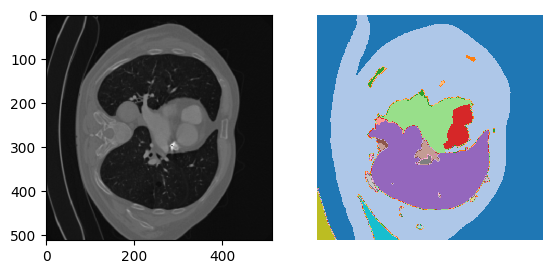

In [9]:
# Let's display the results
# Not too bad!
plot_slice_seg(data_train[2], compute_baseline_one_sample(data_train[2]))

## Let's measure its performances

In [10]:
# Compute the baseline on a whole dataset
def compute_baseline(dataset: np.array):
    labels_predicted_list = []
    for data_index in tqdm(range(len(dataset))):
        data_slice = dataset[data_index]
        label_predicted = compute_baseline_one_sample(data_slice)
        labels_predicted_list.append(label_predicted)
    return pd.DataFrame(np.stack(labels_predicted_list, axis=0).reshape((len(labels_predicted_list), -1)))

In [11]:
# Let's create a validation set first: the 200 first images of the train set 
data_val = data_train[:200]
labels_val = labels_train.iloc[:200]

In [12]:
# Compute baseline on a few train data
labels_val_predicted_baseline = compute_baseline(data_val)

100%|██████████| 200/200 [00:24<00:00,  8.12it/s]


In [13]:
def rand_index_dataset(y_true_df: pd.DataFrame, y_pred_df: pd.DataFrame) -> float:
    """Compute the individual rand index for each sample in the dataset and then average it"""
    individual_rand_index = []
    for row_index in range(y_true_df.values.shape[0]):
        labels = y_true_df.values[row_index]
        preds = y_pred_df.values[row_index]
        individual_rand_index.append(sklearn.metrics.adjusted_rand_score(labels, preds))

    return np.mean(individual_rand_index)

In [14]:
# Compute the metric on the validation set
rand_index_dataset(labels_val, labels_val_predicted_baseline)
# We get => 0.14 (0.1369409193608601); Not so bad, but room for improvements!
# Let's see if you can do better!

0.1369409193608601

# SAM

In [ ]:
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
sam = sam_model_registry["vit_l"](checkpoint="./../checkpoints_sam/sam_vit_l_0b3195.pth")
mask_generator = SamAutomaticMaskGenerator(sam)


In [ ]:
masks = mask_generator.generate(image)

In [ ]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))

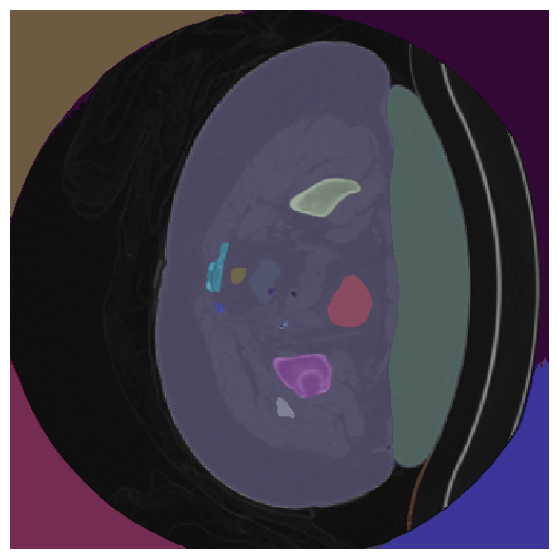

In [ ]:
plt.figure(figsize=(7, 7))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 